# ENTREGABLE 1

## 1. Configuración del entorno de trabajo

### Consigna

- Instalar y configurar un sistema de gestión de bases de datos relacional (PostgreSQL o SQL Server).
- Crear una base de datos de trabajo y preparar el entorno para futuras transformaciones (conexión desde Python vía ORM recomendado).

### Detalle de implementación

Se configuró un entorno de base de datos con Docker utilizando **PostgreSQL**. Este servicio ejecuta PostgreSQL y monta los scripts SQL necesarios para crear las tablas al iniciar. Además, se incluye **Adminer** para gestionar la base de datos de forma gráfica.

El entorno está listo para interactuar con la base de datos desde Python usando **SQLAlchemy** como ORM, lo que facilita la implementación de futuras transformaciones y expansiones del proyecto.

---

## 2. Carga inicial de datos

### Consigna

- Crear tablas e importar datos a partir de los archivos CSV proporcionados.
- Ajustar los tipos de datos según corresponda para preservar la integridad semántica y evitar errores de procesamiento.

### Detalle de implementación

La implementación se realizó en **dos fases**:

### Fase 1: Creación de modelos de tablas e importación de datos

Se crearon modelos de tablas basados en las estructuras de los scripts SQL provistos. En esta fase inicial, no se aplicaron restricciones complejas, sino que se enfocó en asegurar la correcta relación entre tablas mediante claves foráneas y los tipos de datos básicos. El objetivo fue importar los datos desde los archivos CSV y asegurar que las claves foráneas (relación entre tablas) estuvieran correctamente configuradas.

**Ejemplo de implementación:**

```python
class Product(BaseModel):

    __tablename__ = TableNames.PRODUCTS

    product_id: Mapped[int] = mapped_column(ProductColumns.PRODUCT_ID, primary_key=True)
    name: Mapped[str] = mapped_column(ProductColumns.NAME, String)
    description: Mapped[str] = mapped_column(ProductColumns.DESCRIPTION, String)
    price: Mapped[Decimal] = mapped_column(ProductColumns.PRICE, Numeric)
    stock: Mapped[int] = mapped_column(ProductColumns.STOCK, Integer)
    category_id: Mapped[int] = mapped_column(
        CategoryColumns.CATEGORY_ID, ForeignKey("Categorias.CategoriaID"), nullable=False
    )
    category: Mapped["Category"] = relationship("Category", backref="products")

    @classmethod
    def from_dict(cls, data: dict):
        return cls(
            product_id=data.get("product_id"),
            name=data.get("name", "").strip(),
            description=data.get("description", "").strip(),
            price=Decimal(data.get("price", 0)),
            stock=data.get("stock", 0),
            category_id=data.get("category_id"),
        )
```
### Fase  2: Ajustes de tipos de datos y restricciones de integridad

Una vez que los datos fueron importados correctamente, se modificaron los modelos para asegurar la integridad semántica de los datos. Esto incluyó:

- Ajuste de tipos de datos: Se cambiaron algunas columnas para asegurar que almacenaran los datos en el tipo adecuado (por ejemplo, fechas o cadenas con longitud fija).

- Aplicación de restricciones de integridad: Se añadieron restricciones como CHECK y UNIQUE para evitar que los datos violaran las reglas de negocio. Esto garantiza que los datos sean válidos y coherentes con las expectativas del sistema.

**Ejemplo de implementación final (con restricciones):**

```python


class Product(BaseModel):

    __tablename__ = TableNames.PRODUCTS

    __table_args__ = (
        CheckConstraint(
            f"{ProductColumns.STOCK} >= 0", name="stock_non_negative"),
        CheckConstraint(
            f"{ProductColumns.PRICE} >= 0", name="price_non_negative"),
    )

    product_id: Mapped[int] = mapped_column(
        ProductColumns.PRODUCT_ID, primary_key=True)
    name: Mapped[str] = mapped_column(ProductColumns.NAME, String(255))
    description: Mapped[str] = mapped_column(
        ProductColumns.DESCRIPTION, String)
    price: Mapped[Decimal] = mapped_column(ProductColumns.PRICE, Numeric)
    stock: Mapped[int] = mapped_column(ProductColumns.STOCK, Integer)
    category_id: Mapped[int] = mapped_column(
        CategoryColumns.CATEGORY_ID,
        ForeignKey("Categorias.CategoriaID"),
        nullable=False,
    )
    category: Mapped["Category"] = relationship("Category", backref="products")

    @classmethod
    def from_dict(cls, data: dict):
        return cls(
            product_id=data.get("product_id"),
            name=data.get("name", "").strip(),
            description=data.get("description", "").strip(),
            price=Decimal(data.get("price", 0)),
            stock=data.get("stock", 0),
            category_id=data.get("category_id"),
        )

```

---

## 3. Tratamiento de campos semi-estructurados


### Consigna

- Identificar columnas que contengan datos en formatos como JSON, listas, o concatenaciones delimitadas.

- Aplicar técnicas de limpieza y transformación para estructurar adecuadamente la información.


### Identificación de columnas con datos semiestructurados

| **Tabla.Columna**               | **Descripción y ejemplo**                                                       | **Decisión de transformación**                                                                                                                                                       |
|----------------------------------|---------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Categorias.Descripción**       | Es una descripción con ejemplos de la misma separados por comas, ej: 'Teléfonos, computadoras, accesorios y dispositivos inteligentes' | No se normaliza, dado que parece una descripción y las preguntas de negocio no requieren ese nivel de detalle. Mantiene su formato como texto.                                        |
| **MetodosPago.Descripcion**     | Caso similar al de `Categorias.Descripción`, ej: 'Pago con tarjeta de crédito VISA, MasterCard o American Express'                  | No se aplicó transformación, dado que no se requiere conocer marcas de tarjetas, solo la modalidad de pago (ej., 'Tarjeta de Crédito', 'Transferencia Bancaria').                   |

---

## 4.Análisis exploratorio y evaluación de calidad de datos

### Consigna


- Explorar la estructura y el contenido de los datos utilizando consultas SQL.

- Implementar análisis exploratorio complementario en Python mediante un ORM (como SQLAlchemy o psycopg2).

- Detectar valores nulos, duplicados, atípicos y otras inconsistencias.

- Identificar claves primarias y foráneas implícitas, atributos principales y variables relevantes para el negocio.

- Proponer y documentar acciones de preprocesamiento y corrección de calidad de datos.

### Desarrollo de consignas 

#### 1. Explorar la estructura y el contenido de los datos utilizando consultas SQL
En esta fase del análisis, el objetivo principal es obtener una comprensión detallada sobre la estructura y el contenido de las tablas dentro de la base de datos, así como la naturaleza de los datos. Este paso es fundamental porque nos permite identificar las relaciones entre las tablas, la calidad de los datos, y cualquier posible inconsistencia que pueda requerir correcciones antes de realizar análisis más avanzados.


- Consultas de exploración

Consulta para identificar tablas



In [17]:
from app.utils import postgres_utils

query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""
tables = postgres_utils.run_query(query)

tables

,table_name
0,Categorias
1,Productos
2,Usuarios
3,Ordenes
4,DetalleOrdenes
5,DireccionesEnvio
6,Carrito
7,OrdenesMetodosPago
8,MetodosPago
9,ReseñasProductos


Consulta de la estructura de las tablas , pra conocer columnas y tipos de datos de las mismas.

In [2]:

from app.utils import postgres_utils

query_tables_structure = """
        SELECT table_name, column_name, data_type
        FROM information_schema.columns
        WHERE table_schema = 'public'
        ORDER BY table_name, ordinal_position;
    """

df_tables = postgres_utils.run_query(query_tables_structure)

df_tables

,table_name,column_name,data_type
0,Carrito,CarritoID,integer
1,Carrito,UsuarioID,integer
2,Carrito,ProductoID,integer
3,Carrito,Cantidad,integer
4,Carrito,FechaAgregado,timestamp without time zone
5,Categorias,CategoriaID,integer
6,Categorias,Nombre,character varying
7,Categorias,Descripcion,character varying
8,DetalleOrdenes,DetalleID,integer
9,DetalleOrdenes,OrdenID,integer


Consulta para obtener primeros registros de cada tabla:

In [3]:
from app.utils import postgres_utils
import logging

logging.getLogger("sqlalchemy.engine").setLevel(logging.WARNING)

def get_first_records(table_name):
    query = f"SELECT * FROM \"{table_name}\" LIMIT 10;"
    data = postgres_utils.run_query(query)
    return data

tables_list = tables['table_name'].unique()
for table in tables_list:
    data= postgres_utils.run_query(f"SELECT * FROM \"{table}\" LIMIT 5;")
    display(data)


,CategoriaID,Nombre,Descripcion
0,1,Electrónica,"Teléfonos, computadoras, accesorios y disposit..."
1,2,Moda,"Ropa, calzado, bolsos y accesorios para hombre..."
2,3,Hogar y Cocina,"Muebles, electrodomésticos, utensilios y decor..."
3,4,Deportes y Aire Libre,"Equipamiento, ropa deportiva y artículos para ..."
4,5,Belleza y Cuidado Personal,"Cosméticos, productos para el cabello, piel y ..."


,ProductoID,Nombre,Descripcion,Precio,Stock,CategoriaID
0,1,Smartphone Galaxy A54,Teléfono inteligente con pantalla AMOLED y cám...,349.99,50,1
1,2,Laptop Dell Inspiron 15,Laptop para trabajo y estudio con procesador I...,799.00,30,1
2,3,Auriculares Bluetooth Sony,Auriculares inalámbricos con cancelación de ru...,129.99,100,1
3,4,Camiseta Básica Hombre,Camiseta de algodón 100% disponible en varias ...,14.99,200,2
4,5,Jeans Skinny Mujer,Jeans corte skinny de mezclilla azul.,39.99,150,2


,UsuarioID,Nombre,Apellido,DNI,Email,Contraseña,FechaRegistro
0,1,Encarna,Donaire,49877134,encarna.donaire1@correo.com,Contraseña123,2025-07-21 03:28:30.430114
1,2,Jose Ignacio,Canales,98778810,jose ignacio.canales2@correo.com,Contraseña123,2025-07-21 03:28:30.430114
2,3,José,Sebastián,80095714,josé.sebastián3@correo.com,Contraseña123,2025-07-21 03:28:30.430114
3,4,Priscila,Vilar,94128750,priscila.vilar4@correo.com,Contraseña123,2025-07-21 03:28:30.430114
4,5,Epifanio,Ríos,62958342,epifanio.ríos5@correo.com,Contraseña123,2025-07-21 03:28:30.430114


,OrdenID,UsuarioID,FechaOrden,Total,Estado
0,1,153,2024-09-09 09:10:27,393.81,Enviado
1,2,810,2024-09-29 09:10:27,918.85,Completado
2,3,404,2024-11-03 09:10:27,391.29,Pendiente
3,4,52,2024-09-14 09:10:27,250.03,Cancelado
4,5,811,2025-04-11 09:10:27,983.13,Completado


,DetalleID,OrdenID,ProductoID,Cantidad,PrecioUnitario
0,1,833,33,1,425.26
1,2,657,21,4,307.13
2,3,911,15,4,444.75
3,4,818,26,5,346.24
4,5,695,12,3,155.05


,DireccionID,UsuarioID,Calle,Ciudad,Departamento,Provincia,Distrito,Estado,CodigoPostal,Pais
0,1,1,Diagonal Chilecito N° 335,Comodoro Rivadavia,Mendoza,Mendoza,Recoleta,Mendoza,10044733,Argentina
1,2,2,Diagonal Río Negro N° 497,Rawson,Tierra del Fuego,Tierra del Fuego,Palermo,Tierra del Fuego,76007280,Argentina
2,3,3,Blv. Formosa N° 118,Mar del Plata,Salta,Salta,Barracas,Salta,53604249,Argentina
3,4,4,Avenida La Rioja N° 612,San Juan,Neuquén,Neuquén,Flores,Neuquén,91031542,Argentina
4,5,5,Calle Neuquén N° 535,San Juan,Catamarca,Catamarca,Barracas,Catamarca,33002152,Argentina


,CarritoID,UsuarioID,ProductoID,Cantidad,FechaAgregado
0,1,844,22,3,2025-04-29 10:15:10
1,2,901,7,2,2025-05-14 10:15:10
2,3,824,28,1,2025-04-26 10:15:10
3,4,94,5,3,2025-04-20 10:15:10
4,5,228,15,3,2025-05-11 10:15:10


,OrdenMetodoID,OrdenID,MetodoPagoID,MontoPagado
0,1,1,2,580.22
1,2,2,4,638.87
2,3,3,7,946.09
3,4,4,2,390.35
4,5,5,3,908.67


,MetodoPagoID,Nombre,Descripcion
0,1,,
1,2,,
2,3,,
3,4,,
4,5,,


,ReseñaID,UsuarioID,ProductoID,Calificacion,Comentario,Fecha
0,1,898,10,1,"Mala calidad, no lo recomiendo. Ullam sint ali...",2025-07-21 03:28:57.930778
1,2,700,16,3,El producto es aceptable por el precio. Quisqu...,2025-07-21 03:28:57.931192
2,3,173,13,2,"Mala calidad, no lo recomiendo. Illum corporis...",2025-07-21 03:28:57.931234
3,4,557,20,2,No cumplió con lo prometido. Tempore distincti...,2025-07-21 03:28:57.931256
4,5,448,33,2,No cumplió con lo prometido. Modi doloribus re...,2025-07-21 03:28:57.931276


,PagoID,OrdenID,MetodoPagoID,Monto,FechaPago,EstadoPago
0,1,1,4,147.13,2025-07-21 03:29:06.396706,pending
1,2,2,1,647.98,2025-07-21 03:29:06.396859,pending
2,3,3,6,627.45,2025-07-21 03:29:06.396903,pending
3,4,4,5,848.07,2025-07-21 03:29:06.396935,pending
4,5,5,5,189.80,2025-07-21 03:29:06.396967,pending


#### 2.Implementar análisis exploratorio complementario en Python mediante un ORM (como SQLAlchemy o psycopg2).

- Se explora información de las tablas y tipos de datos con pandas 

#### Tabla: Productos

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_table_data("Productos")

#### 1. Información general

* Número de registros: 36
* Número de columnas: 6

#### 2. Esquema

| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| ProductoID  | int64        | 36               | Clave primaria.         |
| Nombre      | object       | 36               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 36               | Texto. Puede contener redundancia. |
| Precio      | float64      | 36               | Valor numérico.                    |
| Stock       | int64        | 36               | Unidades disponibles.              |
| CategoriaID | int64        | 36               | Clave foránea a `Categorias`.      |

Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen
* Las claves numéricas (ProductoID, CategoriaID) son consistentes.

In [8]:
from app.utils import postgres_utils, notebook_utils

notebook_utils.show_duplicates_and_null_info("Productos")

ProductoID     0.0
Nombre         0.0
Descripcion    0.0
Precio         0.0
Stock          0.0
CategoriaID    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (ProductoID, CategoriaID) son consistentes. 

* * **Clave primaria(s):** ProductoID, es unico y sin nulos

* * **Claves foráneas:** CategoriaID

In [11]:
from app.utils import postgres_utils, notebook_utils

notebook_utils.show_table_stats("Productos")

,ProductoID,Precio,Stock,CategoriaID
count,36.000000,36.000000,36.000000,36.00000
mean,18.500000,86.083611,87.777778,6.50000
std,10.535654,164.246313,58.449544,3.50102
min,1.000000,4.500000,20.000000,1.00000
25%,9.750000,19.467500,50.000000,3.75000
50%,18.500000,30.995000,77.500000,6.50000
75%,27.250000,56.247500,102.500000,9.25000
max,36.000000,799.000000,300.000000,12.00000


#### 4. Anáslisis estadístico

__Precio__: La desviación estándar es muy alta ($164.25), indicando gran dispersión.

* * El máximo valor registrado ($799.00) sugiere posible presencia de outliers.

* *  El 25% de los productos cuesta menos de $19.47.

__Stock__: El promedio de unidades en stock es 87.78, con un mínimo de 20 y un máximo de 300.

También se observa una alta dispersión (std = 58.45), lo que sugiere que hay productos con niveles de stock muy dispares.

Number of outliers in 'Precio': 5


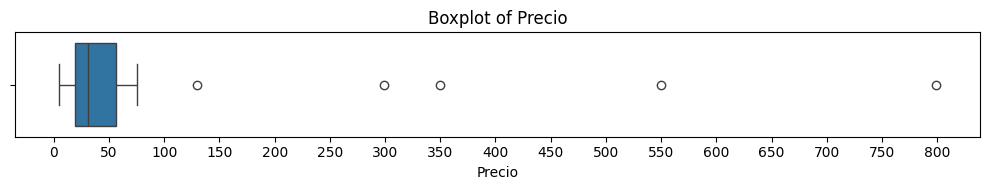

Number of outliers in 'Stock': 3


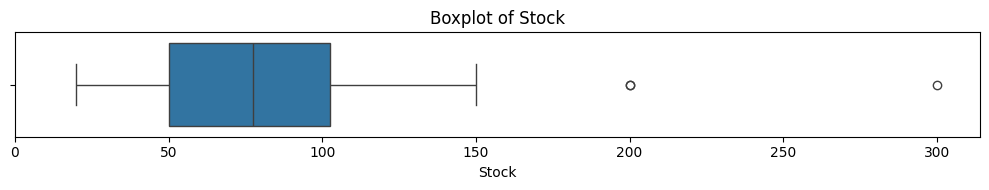

In [12]:
from app.utils import plot_utils

outliers_precio, lower_precio, upper_precio = plot_utils.plot_boxplot_with_outliers('Productos', 'Precio', step=50)

outliers_stock, lower_stock, upper_stock = plot_utils.plot_boxplot_with_outliers('Productos', 'Stock', step=50)

### 4. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Productos`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 4.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 4.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se recomienda mantener chequeos periódicos al integrar datos nuevos.

#### 4.3 Valores atípicos

- **Diagnóstico:** Se identificaron valores atípicos en la columna `Precio`, con un máximo de 799 (muy por encima del tercer cuartil).
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si se confirma que son errores, se sugiere establecer un límite superior al menos a instancias de reporte.
  - Si son válidos, mantenerlos pero tenerlos en cuenta para normalizaciones o transformaciones.

#### 4.4 Consistencia de claves

- **ProductoID:** clave primaria válida, sin duplicados ni nulos.
- **CategoriaID:** clave foránea consistente con la tabla `Categorias`.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 4.5 Texto libre

- **Diagnóstico:** Las columnas `Nombre` y `Descripcion` son campos de texto libre.
- **Acción propuesta:** 
  - Normalizar capitalización.
  - Eliminar espacios dobles o caracteres especiales si existieran.

#### 4.6 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.
- **Acción:** Sin cambios requeridos.

---

**Resumen general:**

| Aspecto             | Acción requerida          |
|---------------------|-------------------------- |
| Valores nulos       | No                        |
| Duplicados          | No                        |
| Outliers            | Validar precios extremos  |
| Claves              | Confirmar constraints     |
| Texto libre         | Normalización recomendada |
| Tipos de datos      | Consistentes              |


#### Tabla: Usuarios

In [24]:
from app.utils import postgres_utils, notebook_utils

notebook_utils.show_table_data("Usuarios")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UsuarioID      1000 non-null   int64         
 1   Nombre         1000 non-null   object        
 2   Apellido       1000 non-null   object        
 3   DNI            1000 non-null   object        
 4   Email          1000 non-null   object        
 5   Contraseña     1000 non-null   object        
 6   FechaRegistro  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 54.8+ KB


None

,UsuarioID,Nombre,Apellido,DNI,Email,Contraseña,FechaRegistro
0,1,Encarna,Donaire,49877134,encarna.donaire1@correo.com,Contraseña123,2025-07-22 03:25:23.980637
1,2,Jose Ignacio,Canales,98778810,jose ignacio.canales2@correo.com,Contraseña123,2025-07-22 03:25:23.980637
2,3,José,Sebastián,80095714,josé.sebastián3@correo.com,Contraseña123,2025-07-22 03:25:23.980637
3,4,Priscila,Vilar,94128750,priscila.vilar4@correo.com,Contraseña123,2025-07-22 03:25:23.980637
4,5,Epifanio,Ríos,62958342,epifanio.ríos5@correo.com,Contraseña123,2025-07-22 03:25:23.980637


#### 1. Información general

* Número de registros: 1000
* Número de columnas: 7

#### 2. Esquema

| Columna       | Tipo de dato | Valores no nulos | Observaciones                         |
| -----------   | ------------ | ---------------- | --------------------------------------|
| UsuarioID     | int64        | 1000             | Clave primaria.                       |
| Nombre        | object       | 1000             | Texto. No hay valores faltantes.      |
| Apellido      | object       | 1000             | Texto.                                |
| email         | object       | 1000             | texto.                                |
| Contraseña    | object       | 1000             | Unidades disponibles.                 |
| FechaRegistro | datetime     | 1000             | Fecha registro de usuario, default now|

Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen
* La columna `Contraseña` debería almacenar un hash, no texto plano.

In [25]:
notebook_utils.show_duplicates_and_null_info("Usuarios")

UsuarioID        0.0
Nombre           0.0
Apellido         0.0
DNI              0.0
Email            0.0
Contraseña       0.0
FechaRegistro    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (UsuarioID) son consistentes. 

* * **Clave primaria(s):** UsuarioID, es unico y sin nulos

* * **Claves foráneas:** -

In [ ]:
from app.utils import postgres_utils, notebook_utils

notebook_utils.show_table_stats("Usuarios")

,UsuarioID,FechaRegistro
count,1000.000000,1000
mean,500.500000,2025-07-21 03:28:30.430114048
min,1.000000,2025-07-21 03:28:30.430114
25%,250.750000,2025-07-21 03:28:30.430114048
50%,500.500000,2025-07-21 03:28:30.430114048
75%,750.250000,2025-07-21 03:28:30.430114048
max,1000.000000,2025-07-21 03:28:30.430114
std,288.819436,NaN


#### 4. Anáslisis estadístico
* No se incluyen estadísticos detallados ya que los valores numéricos (UsuarioID y FechaRegistro) no aportan información relevante al momento


### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Usuarios`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se debe garantizar unicidad de DNI e email al realizar nuevos registros

#### 5.3 Valores atípicos

- **Diagnóstico:** No hay valores numericos atípicos. FechaRegistro presenta un valor constante, probablemente por ser una carga masiva o un default.
- **Acción propuesta:** 
  - Validar proceso de carga de fechaRegistro ya que no hay dispersion. Si se quisiera hacer análisi temporal deben proveerse fechas reales.

#### 5.4 Consistencia de claves

- **ProductoID:** clave primaria válida, sin duplicados ni nulos.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 5.5 Texto libre

- **Diagnóstico:** `Nombre` y `Descripcion` son campos de texto libre.
- **Acción propuesta:** 
  - Validar formato de email.
  - Eliminar espacios dobles o caracteres especiales si existieran.
  - Normalizar nombres (capitalización).


#### 5.6 Tipos de datos

- **Diagnóstico:** `Contraseña`contiene texto.
- **Acción:** Reemplazar texto plano por hashes y nunca almacenar contraseñas en db 

---

**Resumen general:**

| Aspecto           | Acción requerida                      |
| ----------------- | ------------------------------------- |
| Valores nulos     | No                                    |
| Duplicados        | No                                    |
| Outliers          | No relevantes                         |
| Claves            | Asegurar unicidad  en Email y DNI     |
| Texto libre       | Validar y normalizar                  |
| Seguridad         | Hash de contraseñas requerido         |
| Tipos de datos    | Revisar `Email` y `Contraseña`        |
| Fecha de registro | Revisar dispersión / carga automática |



#### Tabla: Categorías

In [ ]:
from app.utils import  notebook_utils

notebook_utils.show_table_data("Categorias")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CategoriaID  12 non-null     int64 
 1   Nombre       12 non-null     object
 2   Descripcion  12 non-null     object
dtypes: int64(1), object(2)
memory usage: 420.0+ bytes


None

,CategoriaID,Nombre,Descripcion
0,1,Electrónica,"Teléfonos, computadoras, accesorios y disposit..."
1,2,Moda,"Ropa, calzado, bolsos y accesorios para hombre..."
2,3,Hogar y Cocina,"Muebles, electrodomésticos, utensilios y decor..."
3,4,Deportes y Aire Libre,"Equipamiento, ropa deportiva y artículos para ..."
4,5,Belleza y Cuidado Personal,"Cosméticos, productos para el cabello, piel y ..."


#### 1. Información general

* Número de registros: 12
* Número de columnas: 3

#### 2. Esquema

| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| CategoriaID | int64        | 12               | Clave primaria.                    |
| Nombre      | object       | 12               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 12               | Texto. Puede contener redundancia. |

Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Categorias")

CategoriaID    0.0
Nombre         0.0
Descripcion    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** 

* * **Clave primaria(s):** CategoriaID, es unico y sin nulos

* * **Claves foráneas:** -

In [3]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("Categorias")

,CategoriaID
count,12.000000
mean,6.500000
std,3.605551
min,1.000000
25%,3.750000
50%,6.500000
75%,9.250000
max,12.000000


#### 4. Anáslisis estadístico
* No se incluyen estadísticos detallados ya que el único valor numérico es el Id

### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Categorias`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados. Sin embargo, en el campo `Nombre` debería garantizarse unicidad. Si dos categorías tienen el mismo nombre (aunque con distinto CategoriaID), podría causar confusión.
- **Acción propuesta:** 
    - Validar unicidad de nombre de categoria  

#### 5.3 Valores atípicos

- **Diagnóstico:** No hay valores numericos atípicos. 

#### 5.4 Consistencia de claves

- **CategoriaID:** clave primaria válida, sin duplicados ni nulos.

#### 5.5 Texto libre

- **Diagnóstico:** `Nombre` y `Descripcion` son campos de texto libre.
- **Acción propuesta:** 
    - Normalizar mayúsculas/minúsculas (ej. todo capitalizado o todo en minúsculas).
    - Eliminar espacios extra antes o después del texto.
    - Eliminar caracteres especiales innecesarios (signos, tabulaciones ocultas).

---

**Resumen general:**

| Aspecto           | Acción requerida                       |
| ----------------- | -------------------------------------  |
| Valores nulos     | No                                     |
| Duplicados        | Prevenir duplicados en columna `Nombre`|
| Outliers          | No relevantes                          |
| Claves            | Asegurar unicidad  en `Nombre`         |
| Texto libre       | Validar y normalizar                   |



#### Tabla: Ordenes

In [4]:
from app.utils import  notebook_utils

notebook_utils.show_table_data("Ordenes")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrdenID     10000 non-null  int64         
 1   UsuarioID   10000 non-null  int64         
 2   FechaOrden  10000 non-null  datetime64[ns]
 3   Total       10000 non-null  float64       
 4   Estado      10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 390.8+ KB


None

,OrdenID,UsuarioID,FechaOrden,Total,Estado
0,1,153,2024-09-09 09:10:27,393.81,Enviado
1,2,810,2024-09-29 09:10:27,918.85,Completado
2,3,404,2024-11-03 09:10:27,391.29,Pendiente
3,4,52,2024-09-14 09:10:27,250.03,Cancelado
4,5,811,2025-04-11 09:10:27,983.13,Completado


#### 1. Información general

* Número de registros: 10000
* Número de columnas: 5

#### 2. Esquema

| Columna    | Tipo de dato     | Valores no nulos | Observaciones                                          |
| ---------- | ---------------- | ---------------- | ------------------------------------------------------ |
| OrdenID    | `int64`          | 10,000           | Clave primaria.                                        |
| UsuarioID  | `int64`          | 10,000           | Clave foránea a `Usuarios`.                            |
| FechaOrden | `datetime64[ns]` | 10,000           | Fecha en que se realizó la orden.                      |
| Total      | `float64`        | 10,000           | Monto total en la orden.                               |
| Estado     | `object`         | 10,000           | Estado de la orden (ej. 'Pendiente', 'Completada').    |


Observaciones
* No hay columnas con valores nulos.
* Estructura: los tipos de datos parecen consistentes al atributo que describen
* Las claves numéricas (OrdenID, UsuarioID) son consistentes.

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Ordenes")

OrdenID       0.0
UsuarioID     0.0
FechaOrden    0.0
Total         0.0
Estado        0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** 

* * **Clave primaria(s):** OrdenID, es unico y sin nulos

* * **Claves foráneas:** UsuarioID

In [9]:
from app.utils import  notebook_utils

notebook_utils.show_table_stats("Ordenes")

,OrdenID,UsuarioID,FechaOrden,Total
count,10000.00000,10000.000000,10000,10000.000000
mean,5000.50000,503.435500,2024-12-30 15:51:12.120000256,507.762898
min,1.00000,1.000000,2024-06-30 09:10:27,20.110000
25%,2500.75000,258.000000,2024-09-29 09:10:27,262.915000
50%,5000.50000,502.500000,2024-12-31 09:10:27,506.795000
75%,7500.25000,755.000000,2025-04-03 09:10:27,750.382500
max,10000.00000,1000.000000,2025-06-30 09:10:27,999.990000
std,2886.89568,288.442075,NaN,281.766761


#### 4. Anáslisis estadístico

__Total__: La desviación estándar es alta ($281.77), indicando gran dispersión.

* * La media y la mediana están muy próximas (~$507), lo que sugiere una distribución relativamente simétrica.

* * El valor mínimo es de $20.11 y el máximo de $999.99, lo que indica una amplia gama de montos posibles.

* * La desviación estándar es alta (~$281), lo que confirma la dispersión de valores.

* * El 25% de las órdenes tienen un valor inferior a ~$262.91 y el 75% están por debajo de ~$750.38.


Number of outliers in 'Total': 0


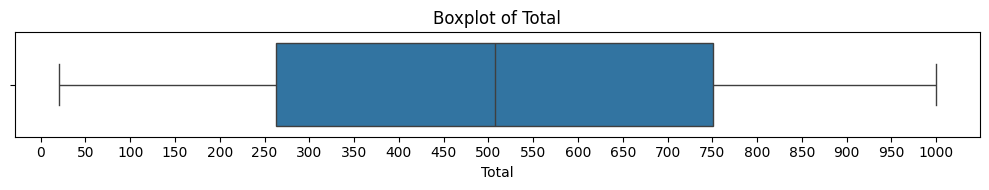

In [1]:
from app.utils import plot_utils

outliers_total, lower_total, upper_total = plot_utils.plot_boxplot_with_outliers('Ordenes', 'Total', step=50)


### 4. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Ordenes`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 4.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 4.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se recomienda mantener chequeos periódicos al integrar datos nuevos.

#### 4.3 Valores atípicos

- **Diagnóstico:** En la columna `Total`, el valor máximo (999.99) es alto respecto al Q3 (750.38), aunque no necesariamente inválido.
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si son válidos, incluirlos y documentar como "transacciones altas" y tomar en cuenta para calculos 


#### 4.4 Consistencia de claves

- **ProductoID:** clave primaria válida, sin duplicados ni nulos.
- **CategoriaID:** clave foránea consistente con la tabla `Usuarios`.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 4.5 Texto libre

- **Diagnóstico:** La columna `Estado` es un campo de texto con posibles valores categóricos como 'Pendiente', 'Completado', 'Cancelado','Enviado'.
- **Acción propuesta:** 
  - Propuesta de mejora estructural: extraer los estados a una tabla aparte y usar un FOREIGN KEY en lugar del texto.

#### 4.6 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.
- **Acción:** No se requiere cambio, aunque la propuesta de usar EstadoID sería una mejora en integridad y eficiencia.

---

**Resumen general:**

| Aspecto            | Acción requerida                        |
| ------------------ | --------------------------------------- |
| Valores nulos      | No                                      |
| Duplicados         | No                                      |
| Outliers           | No                                      |
| Claves             | OK. ASegurar integridad con `Usuarios`  |
| Texto libre        | Normalizar o reemplazar por ID          |
| Tipos de datos     | Consistentes                            |
| Mejora estructural | Sugerida tabla `EstadosOrden`           |


#### Tabla: DetalleOrdenes

In [6]:
from app.utils import  notebook_utils

notebook_utils.show_table_data("DetalleOrdenes")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DetalleID       10000 non-null  int64  
 1   OrdenID         10000 non-null  int64  
 2   ProductoID      10000 non-null  int64  
 3   Cantidad        10000 non-null  int64  
 4   PrecioUnitario  10000 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 390.8 KB


None

,DetalleID,OrdenID,ProductoID,Cantidad,PrecioUnitario
0,1,833,33,1,425.26
1,2,657,21,4,307.13
2,3,911,15,4,444.75
3,4,818,26,5,346.24
4,5,695,12,3,155.05


#### 1. Información general

* Número de registros: 10000
* Número de columnas: 5

#### 2. Esquema

| Columna            | Tipo de dato     | Valores no nulos | Observaciones                                          |
| -----------------  | ---------------- | ---------------- | ------------------------------------------------------ |
| DetalleID          | `int64`          | 10,000           | Clave primaria.                                        |
| OrdenID            | `int64`          | 10,000           | Clave foránea a `Ordenes`.                             |
| ProductoID         | `datetime64[ns]` | 10,000           | Clave foránea a `Productos`.                           |
| Cantidad           | `int64`          | 10,000           | Numero de productos.                                   |
| PrecioUnitario     | `float64`        | 10,000           | Precio de cada producto                                |


Observaciones
* No hay columnas con valores nulos.
* Las claves numéricas (OrdenID, ProductoID) son consistentes.

In [3]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("DetalleOrdenes")

DetalleID         0.0
OrdenID           0.0
ProductoID        0.0
Cantidad          0.0
PrecioUnitario    0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** 

* * **Clave primaria(s):** DetalleID, es unico y sin nulos

* * **Claves foráneas:** OrdenID, referencia a tabla Ordenes (orden a la que pertence el detalle) , ProductoID (Productos)

In [4]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("DetalleOrdenes")

,DetalleID,OrdenID,ProductoID,Cantidad,PrecioUnitario
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,498.860600,18.549300,2.988900,254.936449
std,2886.89568,287.961306,10.446372,1.415407,141.994974
min,1.00000,1.000000,1.000000,1.000000,10.070000
25%,2500.75000,250.750000,9.000000,2.000000,130.800000
50%,5000.50000,498.000000,19.000000,3.000000,255.350000
75%,7500.25000,744.000000,28.000000,4.000000,377.710000
max,10000.00000,1000.000000,36.000000,5.000000,499.900000


#### 4. Anáslisis estadístico
Se evalua columna Cantidad ya que es la que describe comportamiento del usuario , respecto a cuantas unidades compró de un producto

__Cantidad__: La desviación estándar es alta (1.42), coincidiendo con lo sugerido por la mediana y el promedio.

* * La media y la mediana están muy próximas (~3), lo que sugiere una distribución simétrica.

* * El valor mínimo es 1 (lo esperado considerando numero de items)  y el máximo es 5.

* * Aparenta una baja dispersión , que se confirmará en análisis gráfico

Number of outliers in 'Cantidad': 0


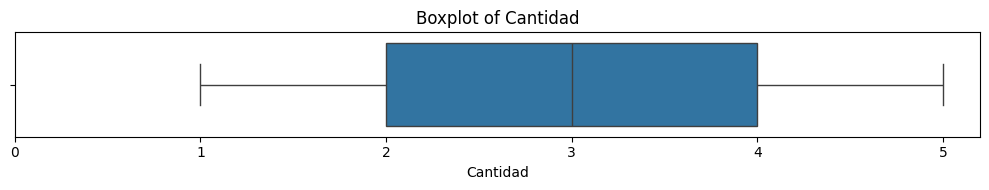

In [5]:
from app.utils import plot_utils

outliers_total, lower_total, upper_total = plot_utils.plot_boxplot_with_outliers('DetalleOrdenes', 'Cantidad', step=1)

### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `DetalleOrdenes`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** En la columna `Total`, el valor máximo (999.99) es alto respecto al Q3 (750.38), aunque no necesariamente inválido.
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si son válidos, incluirlos y documentar como "transacciones altas" y tomar en cuenta para calculos 


#### 5.4 Consistencia de claves

- **DetalleID:** clave primaria válida, sin duplicados ni nulos.
- **OrdenID:** clave foránea consistente con la tabla `Ordenes`.
- **ProductoID:** clave foránea consistente con la tabla `Productos`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---

**Resumen general:**

| Aspecto                    | Acción requerida                            |
| -------------------------- | ------------------------------------------- |
| Valores nulos              | No                                          |
| Duplicados                 | No                                          |
| Outliers                   | No aparentes                                |
| Claves                     | Consistentes                                |
| Tipos de datos             | OK                                          |


#### Tabla: DireccionesEnvio

In [7]:
from app.utils import notebook_utils

notebook_utils.show_table_data("DireccionesEnvio")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DireccionID   1000 non-null   int64 
 1   UsuarioID     1000 non-null   int64 
 2   Calle         1000 non-null   object
 3   Ciudad        1000 non-null   object
 4   Departamento  1000 non-null   object
 5   Provincia     1000 non-null   object
 6   Distrito      1000 non-null   object
 7   Estado        1000 non-null   object
 8   CodigoPostal  1000 non-null   object
 9   Pais          1000 non-null   object
dtypes: int64(2), object(8)
memory usage: 78.3+ KB


None

,DireccionID,UsuarioID,Calle,Ciudad,Departamento,Provincia,Distrito,Estado,CodigoPostal,Pais
0,1,1,Diagonal Chilecito N° 335,Comodoro Rivadavia,Mendoza,Mendoza,Recoleta,Mendoza,10044733,Argentina
1,2,2,Diagonal Río Negro N° 497,Rawson,Tierra del Fuego,Tierra del Fuego,Palermo,Tierra del Fuego,76007280,Argentina
2,3,3,Blv. Formosa N° 118,Mar del Plata,Salta,Salta,Barracas,Salta,53604249,Argentina
3,4,4,Avenida La Rioja N° 612,San Juan,Neuquén,Neuquén,Flores,Neuquén,91031542,Argentina
4,5,5,Calle Neuquén N° 535,San Juan,Catamarca,Catamarca,Barracas,Catamarca,33002152,Argentina


#### 1. Información general

* Número de registros: 1000
* Número de columnas: 10

#### 2. Esquema

| Columna      | Tipo de dato | Valores no nulos | Observaciones                                        |
| ------------ | ------------ | ---------------- | ---------------------------------------------------- |
| DireccionID  | int64        | 1000             | Clave primaria.                                      |
| UsuarioID    | int64        | 1000             | Clave foránea a `Usuarios`.                          |
| Calle        | object       | 1000             | Texto libre.                                         |
| Ciudad       | object       | 1000             | Texto libre.                                         |
| Departamento | object       | 1000             | Texto libre, posible redundancia con `Provincia`.    |
| Provincia    | object       | 1000             | Texto libre.                                         |
| Distrito     | object       | 1000             | Texto libre. Puede no ser aplicable en todos países. |
| Estado       | object       | 1000             | Texto libre. Posible solapamiento con Provincia.     |
| CodigoPostal | object       | 1000             | Alfanumérico, no numérico.                           |
| Pais         | object       | 1000             | Texto libre. Requiere estandarización.               |

Observaciones
* No hay columnas con valores nulos.

* Los tipos de datos son consistentes con los atributos que describen.

* Las claves numéricas (DireccionID, UsuarioID) son consistentes y no tienen valores nulos.

* Se recomienda limpieza y estandarización de los campos de texto (mayúsculas, espacios, abreviaciones).

* Es conveniente evaluar la normalización de campos geográficos para evitar redundancia e inconsistencias.

In [10]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("DireccionesEnvio")

DireccionID     0.0
UsuarioID       0.0
Calle           0.0
Ciudad          0.0
Departamento    0.0
Provincia       0.0
Distrito        0.0
Estado          0.0
CodigoPostal    0.0
Pais            0.0
dtype: float64

np.int64(0)

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (DireccionID, UsuarioID) son consistentes. 

* * **Clave primaria(s):** DireccionID, es unico y sin nulos

* * **Claves foráneas:** UsuarioID

In [23]:
from app.utils import postgres_utils, notebook_utils

data_frame = postgres_utils.run_query("SELECT * FROM \"DireccionesEnvio\";")

notebook_utils.print_colored(f"Exploración frecuencia por campos geográficos", "blue")

notebook_utils.print_colored(f"Frecuencia datos únicos en País", "orange")
country_data = data_frame['Pais'].value_counts(dropna=False)
display(country_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Provincia", "orange")
province_data = data_frame['Provincia'].value_counts(dropna=False)
display(province_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Ciudad", "orange")
city_data= data_frame['Ciudad'].value_counts(dropna=False)
display(city_data)

notebook_utils.print_colored(f"Número de valores únicos para ver la granularidad", "blue")

notebook_utils.print_colored(f"Frecuencia datos únicos en País", "orange")
country_data_unique = data_frame['Pais'].nunique()
display(country_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Provincia", "orange")
province_data_unique = data_frame['Provincia'].nunique()
display(province_data)

notebook_utils.print_colored(f"Frecuencia datos únicos en Ciudad", "orange")
city_data_unique= data_frame['Ciudad'].nunique()
display(city_data)

Pais
Argentina    1000
Name: count, dtype: int64

Provincia
Formosa                55
Chubut                 53
Tierra del Fuego       53
Salta                  52
La Pampa               47
Mendoza                47
Catamarca              46
San Juan               45
Neuquén                44
Córdoba                44
San Luis               44
Entre Ríos             43
Tucumán                43
Río Negro              42
Jujuy                  42
Chaco                  42
Misiones               40
Santa Fe               39
La Rioja               38
Santiago del Estero    37
Buenos Aires           36
Corrientes             34
Santa Cruz             34
Name: count, dtype: int64

Ciudad
San Juan                              49
Bahía Blanca                          43
Córdoba                               42
Resistencia                           41
Ushuaia                               40
Santa Fe                              39
Posadas                               39
Rawson                                38
Río Gallegos                          38
Santa Rosa                            37
La Rioja                              36
Merlo                                 35
Neuquén                               35
San Miguel de Tucumán                 34
Santiago del Estero                   33
Comodoro Rivadavia                    33
San Ferando del Valle de Catamarca    33
Rosario                               33
San Luis                              32
Formosa                               31
Chilecito                             30
La Plata                              29
Corrientes                            29
Mendoza                               28
Viedma   

Pais
Argentina    1000
Name: count, dtype: int64

Provincia
Formosa                55
Chubut                 53
Tierra del Fuego       53
Salta                  52
La Pampa               47
Mendoza                47
Catamarca              46
San Juan               45
Neuquén                44
Córdoba                44
San Luis               44
Entre Ríos             43
Tucumán                43
Río Negro              42
Jujuy                  42
Chaco                  42
Misiones               40
Santa Fe               39
La Rioja               38
Santiago del Estero    37
Buenos Aires           36
Corrientes             34
Santa Cruz             34
Name: count, dtype: int64

Ciudad
San Juan                              49
Bahía Blanca                          43
Córdoba                               42
Resistencia                           41
Ushuaia                               40
Santa Fe                              39
Posadas                               39
Rawson                                38
Río Gallegos                          38
Santa Rosa                            37
La Rioja                              36
Merlo                                 35
Neuquén                               35
San Miguel de Tucumán                 34
Santiago del Estero                   33
Comodoro Rivadavia                    33
San Ferando del Valle de Catamarca    33
Rosario                               33
San Luis                              32
Formosa                               31
Chilecito                             30
La Plata                              29
Corrientes                            29
Mendoza                               28
Viedma   

#### 4. Anáslisis estadístico
Para este caso dado que no hay datos numéricos relevantes, se analizaron algunos campos relevantes a nivel geográfico
__Pais__: 
- **Diagnóstico:** Solo se registran direcciones en un único país: Argentina.
- **Acción:** No se requiere limpieza en este campo, apriori. Sin embargo, se recomienda tabla auxiliar (Paises) para asegurar normalización 

__Provincia__: 
- **Diagnóstico:** Se registran 23 provincias distintas. Leve dispersión, siendo las más frecuentes: Formosa (55), Chubut (53), Tierra del Fuego (53).
- **Acción:** Considerar estandarización y uso de tabla auxiliar para normalizar provincias.

__Ciudad__: 
- **Diagnóstico:** Se detectan 30 ciudades distintas. Algunas ciudades aparecen con nombres largos o compuestos (San Ferando del Valle de Catamarca, San Miguel de Tucumán).
- **Acción:** Considerar estandarización y uso de tabla auxiliar para normalizar. Evaluar si conviene estructurar en una tabla geográfica con jerarquía Provincia -> Ciudad.

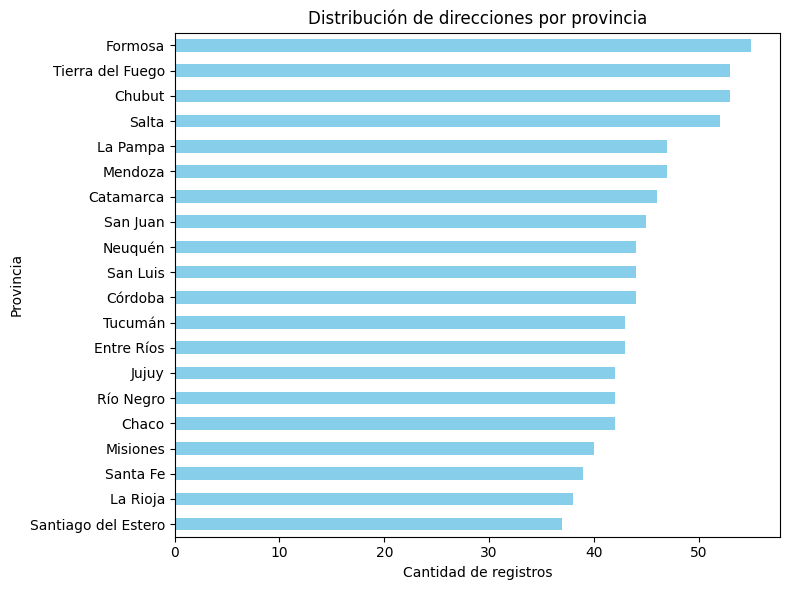

In [24]:
import matplotlib.pyplot as plt

province_data.head(20).sort_values().plot(
    kind='barh',
    figsize=(8, 6),
    color='skyblue'
)

plt.title('Distribución de direcciones por provincia')
plt.xlabel('Cantidad de registros')
plt.ylabel('Provincia')
plt.tight_layout()
plt.show()

### 4. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `DireccionesEnvio`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 4.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** No se requiere imputación o eliminación. Se mantiene la estructura original.

#### 4.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto. Se recomienda mantener chequeos periódicos al integrar datos nuevos.

#### 4.3 Valores atípicos

- **Diagnóstico:** Se identificaron valores atípicos en la columna `Precio`, con un máximo de 799 (muy por encima del tercer cuartil).
- **Acción propuesta:** 
  - Validar si esos valores son errores de carga o válidos.
  - Si se confirma que son errores, se sugiere establecer un límite superior al menos a instancias de reporte.
  - Si son válidos, mantenerlos pero tenerlos en cuenta para normalizaciones o transformaciones.

#### 4.4 Consistencia de claves

- **DireccionID:** clave primaria válida, sin duplicados ni nulos.
- **UsuarioID:** clave foránea consistente con la tabla `Usuarios`.

- **Acción propuesta:**  Asegurar que al importar datos se mantenga integridad referencial. Puede implementarse con constraints.

#### 4.5 Texto libre

- **Diagnóstico:** Varias columnas contienen texto libre (`Provincia`, `Ciudad`, `Calle`, etc.).
- **Acción propuesta:** 
  - Aplicar estandarización de capitalización y formato.
  - Eliminar caracteres especiales o inconsistencias si las hubiera.
  - Sugerencia: migrar a modelo relacional con tablas auxiliares (por ejemplo, Provincias, Paises) para normalizar estos campos y facilitar análisis geográficos.

#### 4.6 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.
- **Acción:** Sin cambios requeridos.

---

**Resumen general:**

| Aspecto            | Acción requerida                        |
| ------------------ | --------------------------------------- |
| Valores nulos      | No                                      |
| Duplicados         | No                                      |
| Texto libre        | Normalización y posible refactor        |
| Claves             | OK. Asegurar integridad con `Usuarios`  |
| Tipos de datos     | Consistentes                            |
| Mejora estructural | Tablas auxiliares para geografía        |


#### Tabla: Carrito

In [25]:
from app.utils import notebook_utils

notebook_utils.show_table_data("Carrito")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CarritoID      5000 non-null   int64         
 1   UsuarioID      5000 non-null   int64         
 2   ProductoID     5000 non-null   int64         
 3   Cantidad       5000 non-null   int64         
 4   FechaAgregado  5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 195.4 KB


None

,CarritoID,UsuarioID,ProductoID,Cantidad,FechaAgregado
0,1,844,22,3,2025-04-29 10:15:10
1,2,901,7,2,2025-05-14 10:15:10
2,3,824,28,1,2025-04-26 10:15:10
3,4,94,5,3,2025-04-20 10:15:10
4,5,228,15,3,2025-05-11 10:15:10


#### 1. Información general

* Número de registros: 5000
* Número de columnas: 5

#### 2. Esquema

| Columna       | Tipo de dato    | Valores no nulos | Observaciones                                 |
| ------------- | --------------- | ---------------- | --------------------------------------------- |
| CarritoID     | int64           | 5000             | Clave primaria.                               |
| UsuarioID     | int64           | 5000             | Clave foránea a `Usuarios`.                   |
| ProductoID    | int64           | 5000             | Clave foránea a `Productos`.                  |
| Cantidad      | int64           | 5000             | Valor numérico, cantidad agregada al carrito. |
| FechaAgregado | datetime64\[ns] | 5000             | Fecha y hora en que se agregó el producto.    |

Observaciones
* No hay columnas con valores nulos.
* No hay columnas con valores nulos.
* Los tipos de datos son consistentes con los atributos que describen. 

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Carrito")

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (ProductoID, UsuarioID) son consistentes. 

* * **Clave primaria(s):** CarritoID, es unico y sin nulos

* * **Claves foráneas:** ProductoID, UsuarioID

In [27]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("Carrito")

,CarritoID,UsuarioID,ProductoID,Cantidad,FechaAgregado
count,5000.000000,5000.000000,5000.000000,5000.000000,5000
mean,2500.500000,505.033000,18.414000,2.006200,2025-05-17 01:53:28.240000256
min,1.000000,1.000000,1.000000,1.000000,2025-04-01 10:15:10
25%,1250.750000,248.000000,10.000000,1.000000,2025-04-25 10:15:10
50%,2500.500000,506.000000,18.000000,2.000000,2025-05-17 10:15:10
75%,3750.250000,762.000000,27.000000,3.000000,2025-06-08 10:15:10
max,5000.000000,1000.000000,36.000000,3.000000,2025-06-30 10:15:10
std,1443.520003,293.110682,10.308009,0.813569,NaN


#### 1. Información general

* Número de registros: 1000
* Número de columnas: 10

#### 2. Esquema

| Columna      | Tipo de dato | Valores no nulos | Observaciones                                        |
| ------------ | ------------ | ---------------- | ---------------------------------------------------- |
| DireccionID  | int64        | 1000             | Clave primaria.                                      |
| UsuarioID    | int64        | 1000             | Clave foránea a `Usuarios`.                          |
| Calle        | object       | 1000             | Texto libre.                                         |
| Ciudad       | object       | 1000             | Texto libre.                                         |
| Departamento | object       | 1000             | Texto libre, posible redundancia con `Provincia`.    |
| Provincia    | object       | 1000             | Texto libre.                                         |
| Distrito     | object       | 1000             | Texto libre. Puede no ser aplicable en todos países. |
| Estado       | object       | 1000             | Texto libre. Posible solapamiento con Provincia.     |
| CodigoPostal | object       | 1000             | Alfanumérico, no numérico.                           |
| Pais         | object       | 1000             | Texto libre. Requiere estandarización.               |

Observaciones
* No hay columnas con valores nulos.

* Los tipos de datos son consistentes con los atributos que describen.

* Las claves numéricas (DireccionID, UsuarioID) son consistentes y no tienen valores nulos.

* Se recomienda limpieza y estandarización de los campos de texto (mayúsculas, espacios, abreviaciones).

* Es conveniente evaluar la normalización de campos geográficos para evitar redundancia e inconsistencias.

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("Carrito")

#### 3. Calidad de datos
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** los tipos de datos parecen consistentes al atributo que describen

* **Claves:** Las claves numéricas (DireccionID, UsuarioID) son consistentes. 

* * **Clave primaria(s):** DireccionID, es unico y sin nulos

* * **Claves foráneas:** UsuarioID

In [ ]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("Carrito")

#### 4. Anáslisis estadístico
Se evalúa la columna Cantidad, ya que representa el comportamiento del usuario respecto a cuántas unidades de un producto agregó al carrito.

__Cantidad__: La desviación estándar es baja (0.81) lo que indica baja dispersion, que coincide con lo sugerido por la media y la mediana

* * La media y la mediana están muy próximas (~2), lo que sugiere una distribución simétrica.

* * El valor mínimo es 1 (lo esperado considerando numero de items)  y el máximo es 3.

* * Aparenta una baja dispersión , que se confirmará en análisis gráfico


Se evalúa la columna FechaAgregado, ya que pede aportar información de estacionalidad

__FechaAgregado__: 

* * Los valores abarcan desde el 1 de abril de 2025 hasta el 30 de junio de 2025.

* * Puede utilizarse para explorar tendencias temporales, como frecuencia de agregado por día o mes.



### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Carrito`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** La columna Cantidad muestra valores entre 1 y 3. No se detectan valores fuera de rango ni anomalías evidentes.
- **Acción propuesta:** :No se requieren transformaciones


#### 5.4 Consistencia de claves

- **CarritoID:** clave primaria válida, sin duplicados ni nulos.
- **UsuarioID:** clave foránea consistente con la tabla `Usuarios`.
- **ProductoID:** clave foránea consistente con la tabla `Productos`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---

**Resumen general:**

| Aspecto        | Acción requerida                         |
| -------------- | ---------------------------------------- |
| Valores nulos  | No                                       |
| Duplicados     | No                                       |
| Outliers       | No. Rango controlado en `Cantidad`       |
| Claves         | OK. Validar integridad en futuras cargas |


#### Tabla: MetodosPago

In [1]:
from app.utils import notebook_utils

notebook_utils.show_table_data("MetodosPago")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MetodoPagoID  7 non-null      int64 
 1   Nombre        7 non-null      object
 2   Descripcion   7 non-null      object
dtypes: int64(1), object(2)
memory usage: 300.0+ bytes


None

,MetodoPagoID,Nombre,Descripcion
0,1,Tarjeta de Crédito,"Pago con tarjeta de crédito VISA, MasterCard o..."
1,2,Tarjeta de Débito,Pago con tarjeta de débito emitida por cualqui...
2,3,Transferencia Bancaria,Transferencia directa a nuestra cuenta bancaria
3,4,Pago Contra Entrega,Paga en efectivo cuando recibes tu pedido
4,5,Mercado Pago,Pago a través de la pasarela Mercado Pago


1. Información general
Número de registros: 5

Número de columnas: 3

2. Esquema de columnas
 
| Columna        | Tipo de dato | Valores no nulos | Observaciones                                                 |
| -------------- | ------------ | ---------------- | ------------------------------------------------------------- |
| `MetodoPagoID` | int64        | 5                | Clave primaria. Identificador único del método de pago.       |
| `Nombre`       | object       | 5                | Nombre del método de pago. Texto breve, sin valores nulos.    |
| `Descripcion`  | object       | 5                | Texto descriptivo. Puede tener redundancia o ser muy general. |


In [3]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("MetodosPago")

MetodoPagoID    0.0
Nombre          0.0
Descripcion     0.0
dtype: float64

np.int64(0)

3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** Los tipos de datos son adecuados.

* Claves:

**Clave primaria(s):** MetodoPagoID

**Claves foráneas:** ... (si aplica)

**Limpieza potencial:** columnas como `Nombre` podrían requerir normalización o validación de categorías.

### 4. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `Metodos de pago`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 4.1 Valores nulos o duplicado

- **Diagnóstico:** No se encontraron columnas con valores nulos ni filas duplicadas
- **Acción:** Se mantiene la estructura original.

#### 4.2 Consistencia de claves

- **MetodoPagoID:** clave primaria válida, sin duplicados ni nulos.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 4.5 Tipos de datos
- Todos los tipos de datos son consistentes con el dominio del atributo.

#### 4.5 Texto libre
- **Diagnóstico:** La columna `Nombre` contiene texto libre, lo cual podría generar inconsistencias si se repiten registros con variantes tipográficas (mayúsculas, espacios, etc.).
- **Acción:**
- - Validar que Nombre contenga valores únicos y estandarizados.
- - Mantener esta tabla como auxiliar de medios de pago, usando la clave MetodoPagoID para referencias externas.Esta estructura podría facilitar futuras extensiones (como agregar marcas de tarjeta o condiciones específicas por método).



---

**Resumen general:**

| Aspecto            | Acción requerida                                  |
| ------------------ | ------------------------------------------------- |
| Valores nulos      | No                                                |
| Duplicados         | No                                                |
| Claves             | OK. Validar integridad referencial si corresponde |
| Tipos de datos     | OK                                                |
| Estandarización    | Recomendada en `Nombre`                           |
| Mejora estructural | Mantener como tabla auxiliar                      |


#### Tabla: OrdenesMetodosPago

In [4]:
from app.utils import notebook_utils

notebook_utils.show_table_data("OrdenesMetodosPago")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OrdenMetodoID  10000 non-null  int64  
 1   OrdenID        10000 non-null  int64  
 2   MetodoPagoID   10000 non-null  int64  
 3   MontoPagado    10000 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 312.6 KB


None

,OrdenMetodoID,OrdenID,MetodoPagoID,MontoPagado
0,1,1,2,580.22
1,2,2,4,638.87
2,3,3,7,946.09
3,4,4,2,390.35
4,5,5,3,908.67


1. Información general
- Número de registros: 10000

- Número de columnas: 4

2. Esquema de columnas
 
| Columna         | Tipo de dato | Valores no nulos | Observaciones                                                       |
| --------------- | ------------ | ---------------- | ------------------------------------------------------------------- |
| `OrdenMetodoID` | int64        | 10,000           | Clave primaria. Identificador único del registro de pago por orden. |
| `OrdenID`       | int64        | 10,000           | Clave foránea a `Ordenes`.                                          |
| `MetodoPagoID`  | int64        | 10,000           | Clave foránea a `MetodosPago`.                                      |
| `MontoPagado`   | float64      | 10,000           | Monto abonado por ese método en la orden.                           |



In [ ]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("OrdenesMetodosPago")




3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados (df.duplicated().sum()).

* **Tipos de datos:** Los tipos de datos son adecuados.

* Claves:

**Clave primaria(s):** OrdenMetodoID

**Claves foráneas:** OrdenID, MetodoPagoID, consistentes. 


In [6]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("OrdenesMetodosPago")


,OrdenMetodoID,OrdenID,MetodoPagoID,MontoPagado
count,10000.00000,10000.00000,10000.000000,10000.000000
mean,5000.50000,5000.50000,4.043400,551.040996
std,2886.89568,2886.89568,1.995925,262.069448
min,1.00000,1.00000,1.000000,100.050000
25%,2500.75000,2500.75000,2.000000,319.860000
50%,5000.50000,5000.50000,4.000000,554.265000
75%,7500.25000,7500.25000,6.000000,777.910000
max,10000.00000,10000.00000,7.000000,999.950000



#### 4. Anáslisis estadístico
Se evalúa la columna `MontoPagado:`, que representa el importe abonado por cada método de pago vinculado a una orden. 

__MontoPagado__: La desviación estándar es baja (262) lo que indica bastante dispersion, lo cual es esperable considerando la dispersion de precios en los productos y la posibilidad de desglosar una misma orden en varios medios de pago

* * La media y la mediana están muy próximas (~$551.04-$554.26), lo que sugiere una distribución simétrica.

* * El valor mínimo registrado es $100.05 y el máximo $999.95, lo que abarca prácticamente el rango total de pagos posibles en la plataforma.

* * Aparenta una considerable dispersión , que se confirmará en análisis gráfico


Number of outliers in 'MontoPagado': 0


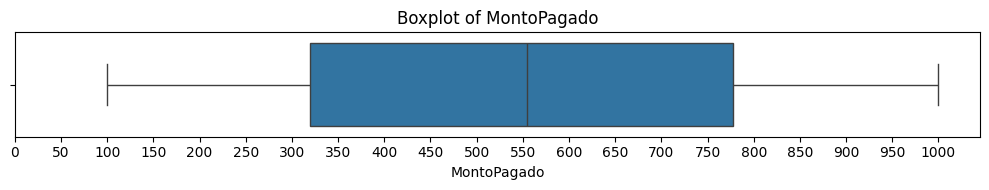

In [7]:
from app.utils import plot_utils

outliers, lower, upper = plot_utils.plot_boxplot_with_outliers('OrdenesMetodosPago', 'MontoPagado', step=50)

### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `'OrdenesMetodosPago'`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** Los valores de `MontoPagado` oscilan entre 100.05 y 999.95, sin valores fuera de un rango lógico.
- **Acción propuesta:** :No se requieren transformaciones, la distribución es simetrica y no hay outliers :
- - Dispersión: El rango intercuartílico (IQR) va de aproximadamente 319.86 a 777.91, y la mediana es cercana a la media (554.27), lo que sugiere una distribución simétrica y sin sesgo evidente.

Visualización: Un boxplot muestra una distribución pareja, sin valores atípicos destacables.


#### 5.4 Consistencia de claves

- **OrdenMetodoID:** clave primaria válida, sin duplicados ni nulos.
- **OrdenID:** clave foránea consistente con la tabla `Ordenes`.
- **MetodoPagoID:** clave foránea consistente con la tabla `MetodosPago`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---

**Resumen general:**

| Aspecto        | Acción requerida                            |
| -------------- | ------------------------------------------- |
| Valores nulos  | No                                          |
| Duplicados     | No                                          |
| Outliers       | No evidentes, dispersión moderada en montos |
| Claves         | OK. Validar integridad en futuras cargas    |
| Tipos de datos | Consistentes                                |


#### Tabla: ReseñasProductos


In [14]:
from app.utils import notebook_utils

notebook_utils.show_table_data("ReseñasProductos")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ReseñaID      10000 non-null  int64         
 1   UsuarioID     10000 non-null  int64         
 2   ProductoID    10000 non-null  int64         
 3   Calificacion  10000 non-null  int64         
 4   Comentario    10000 non-null  object        
 5   Fecha         10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 468.9+ KB


None

,ReseñaID,UsuarioID,ProductoID,Calificacion,Comentario,Fecha
0,1,898,10,1,"Mala calidad, no lo recomiendo. Ullam sint ali...",2025-07-22 03:25:35.284709
1,2,700,16,3,El producto es aceptable por el precio. Quisqu...,2025-07-22 03:25:35.284828
2,3,173,13,2,"Mala calidad, no lo recomiendo. Illum corporis...",2025-07-22 03:25:35.284867
3,4,557,20,2,No cumplió con lo prometido. Tempore distincti...,2025-07-22 03:25:35.284895
4,5,448,33,2,No cumplió con lo prometido. Modi doloribus re...,2025-07-22 03:25:35.284918



1. Información general
Número de registros: 10000
Número de columnas: 6

2. Esquema de columnas
 
| Columna        | Tipo de dato    | Valores no nulos | Observaciones                                                     |
| -------------- | --------------- | ---------------- | ----------------------------------------------------------------- |
| `ReseñaID`     | int64           | 10,000           | Clave primaria. Identificador único de cada reseña.               |
| `UsuarioID`    | int64           | 10,000           | Clave foránea a `Usuarios`.                                       |
| `ProductoID`   | int64           | 10,000           | Clave foránea a `Productos`.                                      |
| `Calificacion` | int64           | 10,000           | Escala discreta de 1 a 5. Restricción CHECK definida.             |
| `Comentario`   | object (texto)  | 10,000           | Texto libre. Puede requerir limpieza (espacios, caracteres, etc). |
| `Fecha`        | datetime64\[ns] | 10,000           | Fecha y hora de la reseña.           |


In [15]:
from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("ReseñasProductos")


CarritoID        0.0
UsuarioID        0.0
ProductoID       0.0
Cantidad         0.0
FechaAgregado    0.0
dtype: float64

np.int64(0)

3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados.

* **Tipos de datos:** Los tipos de datos son adecuados

* Claves:

**Clave primaria(s):** ReseñaID, única y sin valores nulos.

**Claves foráneas:** UsuarioID y ProductoID, ambas apuntan a las tablas Usuarios y Productos respectivamente.

**Limpieza potencial:** columnas como ... podrían requerir normalización, limpieza de texto o validación de categorías.



In [17]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("ReseñasProductos")

,ReseñaID,UsuarioID,ProductoID,Calificacion,Fecha
count,10000.00000,10000.000000,10000.000000,10000.000000,10000
mean,5000.50000,500.963600,18.563400,2.995500,2025-07-22 03:25:35.385861888
min,1.00000,1.000000,1.000000,1.000000,2025-07-22 03:25:35.284709
25%,2500.75000,252.000000,10.000000,2.000000,2025-07-22 03:25:35.326602752
50%,5000.50000,506.000000,19.000000,3.000000,2025-07-22 03:25:35.392456448
75%,7500.25000,754.000000,28.000000,4.000000,2025-07-22 03:25:35.437829888
max,10000.00000,1000.000000,36.000000,5.000000,2025-07-22 03:25:35.478361
std,2886.89568,287.968426,10.344065,1.400384,NaN



#### 4. Anáslisis estadístico
Se evalúa la columna `Calificacion`, ya que representa la opinión del usuario sobre un producto.

__Calificacion__: La desviación estándar (1.40) indica una dispersión moderada, lo cual es esperable dado el rango de 5 niveles posibles.

* * La media (2.99) y la mediana (3) están prácticamente alineadas, lo que sugiere una distribución simétrica.

* * El valor mínimo es 1 y el máximo es 5, dentro del rango permitido por la restricción CHECK.




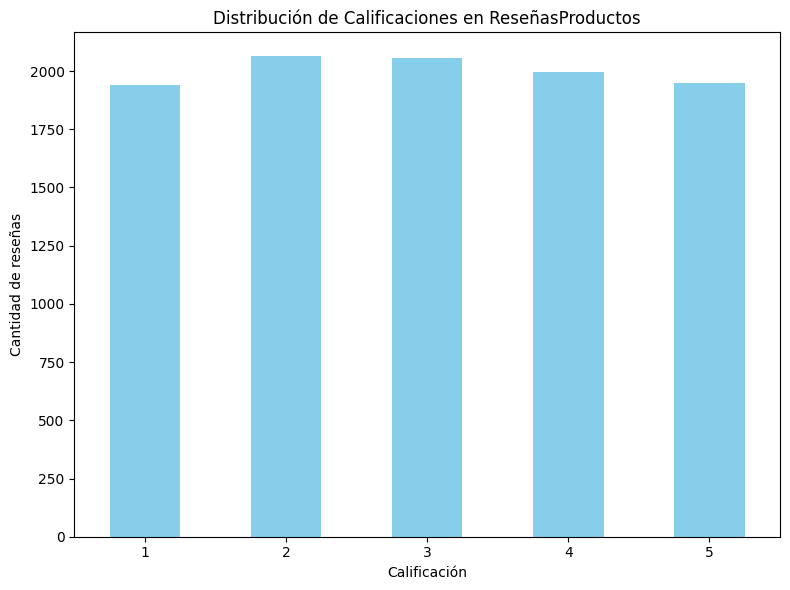

In [20]:
import matplotlib.pyplot as plt

data_frame = postgres_utils.run_query("SELECT \"Calificacion\" FROM \"ReseñasProductos\";")
frequency = frecuencias = data_frame['Calificacion'].value_counts().sort_index()
frequency.plot(
    kind='bar',
    figsize=(8, 6),
    color='skyblue'
)

plt.title('Distribución de Calificaciones en ReseñasProductos')
plt.xlabel('Calificación')
plt.ylabel('Cantidad de reseñas')
plt.xticks(rotation=0)  # para que los números estén horizontales
plt.tight_layout()
plt.show()

### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `ReseñasProductos`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** La columna Cantidad muestra valores entre 1 y 5.  conforme al rango esperado y sin valores fuera de rango ni anomalías.
- **Acción propuesta:** :No se requieren transformaciones


#### 5.4 Consistencia de claves

- **ReseñaID:** clave primaria válida, sin duplicados ni nulos.
- **UsuarioID:** clave foránea consistente con la tabla `Usuarios`.
- **ProductoID:** clave foránea consistente con la tabla `Productos`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

---
| Aspecto        | Acción requerida                                  |
| -------------- | ------------------------------------------------- |
| Valores nulos  | No                                                |
| Duplicados     | No                                                |
| Outliers       | No, rango esperado y controlado en `Calificacion` |
| Claves         | OK. Validar integridad en futuras cargas          |
| Tipos de datos | Adecuados, posible limpieza en texto `Comentario` |
| Distribución   | Balanceada, no requiere ajustes                   |


In [21]:
from app.utils import notebook_utils

notebook_utils.show_table_data("HistorialPagos")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   PagoID        10000 non-null  int64         
 1   OrdenID       10000 non-null  int64         
 2   MetodoPagoID  10000 non-null  int64         
 3   Monto         10000 non-null  float64       
 4   FechaPago     10000 non-null  datetime64[ns]
 5   EstadoPago    10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 468.9+ KB


None

,PagoID,OrdenID,MetodoPagoID,Monto,FechaPago,EstadoPago
0,1,1,4,147.13,2025-07-22 03:25:37.199927,pending
1,2,2,1,647.98,2025-07-22 03:25:37.200268,pending
2,3,3,6,627.45,2025-07-22 03:25:37.200343,pending
3,4,4,5,848.07,2025-07-22 03:25:37.200381,pending
4,5,5,5,189.80,2025-07-22 03:25:37.200421,pending


#### Tabla: HistorialPagos

1. Información general
Número de registros: 10000
Número de columnas: 6

2. Esquema de columnas
 
| Columna        | Tipo de dato    | Valores no nulos | Observaciones                                       |
| -------------- | --------------- | ---------------- | --------------------------------------------------- |
| `PagoID`       | `SERIAL`        | 10000            | Clave primaria, identificador único de pago.        |
| `OrdenID`      | `INT`           | 10000            | Clave foránea referenciando la tabla `Ordenes`.     |
| `MetodoPagoID` | `INT`           | 10000            | Clave foránea referenciando la tabla `MetodosPago`. |
| `Monto`        | `DECIMAL(10,2)` | 10000            | Monto total del pago realizado.                     |
| `FechaPago`    | `TIMESTAMP`     | 10000            | Fecha y hora del pago.                              |
| `EstadoPago`   | `VARCHAR(50)`   | 10000            | Estado del pago, por defecto 'Procesando'.          |



In [22]:

from app.utils import notebook_utils

notebook_utils.show_duplicates_and_null_info("HistorialPagos")

PagoID          0.0
OrdenID         0.0
MetodoPagoID    0.0
Monto           0.0
FechaPago       0.0
EstadoPago      0.0
dtype: float64

np.int64(0)

In [ ]:

3. Observaciones generales
* **Valores nulos:** No se encontraron columnas con valores faltantes.

* **Duplicados:** No se detectaron registros duplicados (df.duplicated().sum()).

* **Tipos de datos:** Los tipos de datos son adecuados

* Claves:

**Clave primaria(s):** PagoID

**Claves foráneas:** 
 * * OrdenID es clave foránea consistente con la tabla Ordenes.
    * * MetodoPagoID es clave foránea consistente con la tabla MetodosPago.

**Limpieza potencial:** La columna EstadoPago es candidata a normalización o refactor
        


In [23]:
from app.utils import notebook_utils

notebook_utils.show_table_stats("HistorialPagos")


,PagoID,OrdenID,MetodoPagoID,Monto,FechaPago
count,10000.00000,10000.00000,10000.000000,10000.000000,10000
mean,5000.50000,5000.50000,4.013800,551.020499,2025-07-22 03:25:37.338594304
min,1.00000,1.00000,1.000000,100.030000,2025-07-22 03:25:37.199927
25%,2500.75000,2500.75000,2.000000,328.212500,2025-07-22 03:25:37.270445056
50%,5000.50000,5000.50000,4.000000,549.000000,2025-07-22 03:25:37.336937472
75%,7500.25000,7500.25000,6.000000,779.440000,2025-07-22 03:25:37.407772928
max,10000.00000,10000.00000,7.000000,999.730000,2025-07-22 03:25:37.519935
std,2886.89568,2886.89568,1.990378,260.458342,NaN




#### 4. Anáslisis estadístico
A partir de las estadísticas descriptivas de las columnas de la tabla HistorialPagos, tenemos los siguientes puntos relevantes:


__Monto__: 
* * Desviación estándar: 260.46, lo que significa que hay una considerable variabilidad en los montos, lo que sugiere que la tabla incluye una gama amplia de pagos.

* * La media es 551.02
* * El valor mínimo es apx 100 y el máximo 999.73, lo cual conincide con análisis previos vinculados a pagos.

Se evalúa la columna FechaAgregado, ya que pede aportar información de estacionalidad

__MetodoPagoID__:
* * Valor mínimo 1 y máximo 7, estos referen a los Ids y están dentro del rango de medios de pago disponibles.



### 5. Resumen de análisis y acciones propuestas de preprocesamiento y calidad de datos

A partir del análisis exploratorio de la tabla `HistorialPagos`, se proponen las siguientes acciones de limpieza y mejora de calidad:

#### 5.1 Valores nulos

- **Diagnóstico:** No se encontraron columnas con valores nulos.
- **Acción:** Se mantiene la estructura original.

#### 5.2 Duplicados

- **Diagnóstico:** No se detectaron registros duplicados.
- **Acción:** No se requiere limpieza en este aspecto.

#### 5.3 Valores atípicos

- **Diagnóstico:** El campo Monto tiene pagos con un rango entre 100.03 y 999.73. Sin embargo, dada la alta desviación estándar (260.46), es recomendable analizar los valores extremos más cercanos al máximo para verificar si corresponden a transacciones legítimas.
- **Acción propuesta:** :No se requieren transformaciones


#### 5.4 Consistencia de claves

- **PagoID:** clave primaria válida, sin duplicados ni nulos.
- **OrdenID:** clave foránea consistente con la tabla `Ordenes`.
- **MetodoPagoID:** clave foránea consistente con la tabla `MetodosPago`.

- **Acción propuesta:**  Asegurar que las claves se mantengan válidas y con constraints activos en procesos de carga.

#### 5.5 Tipos de datos

- Todos los tipos de datos son consistentes con el dominio del atributo.

#### 5.6 Texto libre

- **Diagnóstico:** La columna `EstadoPago` es un campo de texto con posibles valores categóricos como 'Pendiente', 'Pagado', 'Procesado','Fallido', 'Reembolsado'.
- **Acción propuesta:** 
  - Propuesta de mejora estructural: extraer los estados a una tabla aparte y usar un FOREIGN KEY en lugar del texto.

---

**Resumen general:**

| Aspecto        | Acción requerida                                                                         |
| -------------- | ---------------------------------------------------------------------------------------- |
| Valores nulos  | No                                                                                       |
| Duplicados     | No                                                                                       |
| Outliers       | Revisar pagos extremos en `Monto`                                                        |
| Claves         | Validar integridad referencial en futuras cargas                                         |
| Tipos de datos | Adecuados, sin necesidad de transformaciones                                             |
| EstadoPago     | Asegurarse de que los pagos se actualicen a "confirmado" o "cancelado" según corresponda |
